<a href="https://colab.research.google.com/github/Apurbodas31/GAN_for_TB/blob/main/GAN_for_TB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows code for building and training a GAN network with TB affected Chest X-Ray images.

**1. Import Dependencies and Dataset**

In [2]:
# Check which GPU is available if any
!nvidia-smi

Sat May 27 14:21:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import all dependencies
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization, LeakyReLU)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.initializers import RandomNormal
from keras.optimizers import Adam
import time
import pickle
import cv2
from IPython.display import clear_output
import imageio
from keras.models import load_model
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import io, transform, color

In [4]:
# For image preprocessing set image width, height and channel
width, height, channel = 256, 256, 1

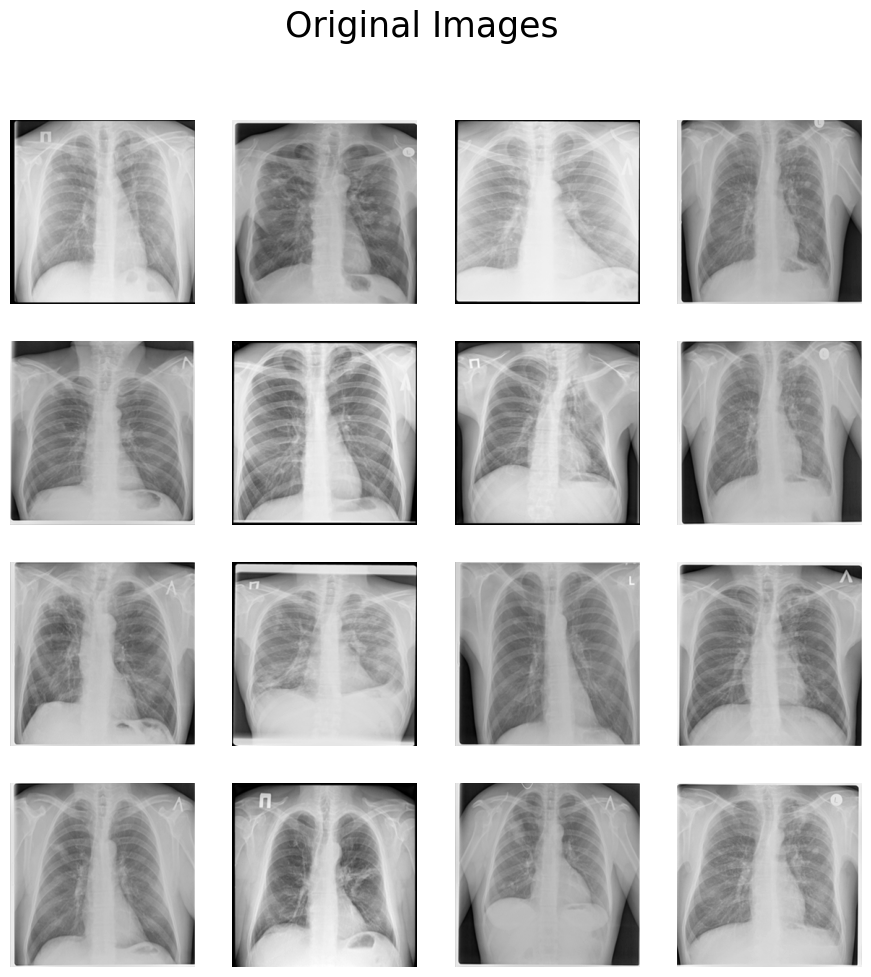

In [5]:
# Load dataset
data_dir = '/content/drive/MyDrive/Dataset/TB_Chest_Radiography_Database/Tuberculosis'
img_list = os.listdir(data_dir)

X = []
for img_path in img_list:
    img = Image.open(os.path.join(data_dir, img_path)).convert('L').resize((width, height))
    X.append(np.array(img))

X = np.array(X)

# To use 'tanh' the image values has to be normalized to [-1,1]
X = (X - 127.5) / 127.5

# Show some images from dataset
def show_data(X, title=""):
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in X:
        plt.subplot(4, 4, i)
        img = 0.5 * img + 0.5
        plt.imshow(img.reshape((height, width, channel)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>16: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    
show_data(X, title="Original Images")

**2. Build the GAN**

In [6]:
# As generator optimizer Adam is used with learning rate 0.0001 and beta1 parameter 0.5
# It determines the exponential decay rate for the first moment estimates
gen_optimizer = Adam(0.0001, 0.5)

# As discriminator optimizer Adam is used with learning rate 0.00001 slower than generator and beta1 parameter 0.5
disc_optimizer = Adam(0.00001, 0.5)

# Dimentionality of noise vector
noise_dim = 128

In [7]:
# Define generator model
def buildGenerator():
    # Initilize model
    model = Sequential()

    # First layer block
    model.add(Dense(2048, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    # Second layer block
    model.add(Dense(131072, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    # Reshape the vector
    model.add(Reshape((32, 32, 128)))
    
    # Third layer block
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    # Fourth layer block
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    # Fifth layer block with 'tanh' to get to one channel
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(channel, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [8]:
# Summary of the generator model
generator = buildGenerator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              264192    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 131072)            268566528 
                                                                 
 batch_normalization_1 (Batc  (None, 131072)           524288    
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 131072)            0

In [9]:
# Define discriminator model
def buildDiscriminator():
    # Initilize model
    model = Sequential()
    
    # First layer block
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(width, height, channel)))
    model.add(LeakyReLU(0.2))
    
    # Second layer block
    model.add(Conv2D(128, (5, 5), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    # Flatten the vector to one dimention
    model.add(Flatten())

    # Third layer block
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    # Fourth layer block
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model with binary crossentropy for loss calculation
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [10]:
# Summary of the discriminator model
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 128)       204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 62, 62, 128)       0         
                                                                 
 flatten (Flatten)           (None, 492032)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               125960448 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)              

**3. Train the GAN and save the weights and model**

In [ ]:
# Define the input layer for the noise vector
noise = Input(shape=(noise_dim,))

# Generate fake data using the generator model
fake_data = generator(noise)

# Set the discriminator as non-trainable during GAN training
discriminator.trainable = False

# Pass the fake data through the discriminator to get the output
output = discriminator(fake_data)

# Create the GAN model by connecting the noise input to the discriminator output
gan = Model(noise, output)

# Compile the GAN model with the binary cross-entropy loss and generator optimizer
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

Run the cell below to generate and store the fixed noises for the first time. These noises will be used to generate intermediate images as the GAN is trained. As the GAN is trained in multiple sessions, after initial setup this cell should not be executed unless intended.

In [ ]:
# Generate a fixed noise vector using a normal distribution
fixed_noise = np.random.normal(0, 1, size=(4, noise_dim))

# Save the fixed noise vector to a file using pickle
with open('/content/drive/MyDrive/Models/Weight/fixed_noise.pkl', 'wb') as f:
    pickle.dump(fixed_noise, f)

In [11]:
# Function to generate intermideate images as the GAN trains
def show_generated_images(title, epoch):
    # Generating images
    imgs = generator.predict(fixed_noise)

    # Rescale the generated images from [-1,1] to [0,1]
    imgs = 0.5 * imgs + 0.5

    # Plotting and saving the images
    plt.figure(figsize=(12, 3))

    plt.subplots_adjust(wspace=0.05)

    for i, img in enumerate(imgs):
        plt.subplot(1, 4, i+1)
        plt.imshow(img.reshape((height, width, channel)), cmap='gray')
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.savefig("/content/drive/MyDrive/Dataset/Test/" + str(epoch) + ".png", transparent=True)
    plt.show()

In [12]:
# Define the starting and ending epochs for training
start_epoch = 2501      #initially 0
end_epoch = 3001

# Set the batch size for training
batch_size = 64

# Calculate the number of steps per epoch
steps_per_epoch = len(X)//batch_size

# Print the number of steps per epoch
print(steps_per_epoch)

10


The cell below should be run only when weights of the previous session training is saved and available. The location of the weight has to be specified and the GAN will start training from there. Load the saved noise vector to generate intermediate images. For initial run this cell does't need to be executed.

In [ ]:
# Load the saved weights of the GAN model
gan.load_weights('/content/drive/MyDrive/Models/Weight/2500_gan_weights.hdf5')

# Load the fixed noise vector from a file using pickle
with open('/content/drive/MyDrive/Models/Weight/fixed_noise.pkl', 'rb') as f:
    fixed_noise = pickle.load(f)

1/1 [==============================] - 0s 18ms/step


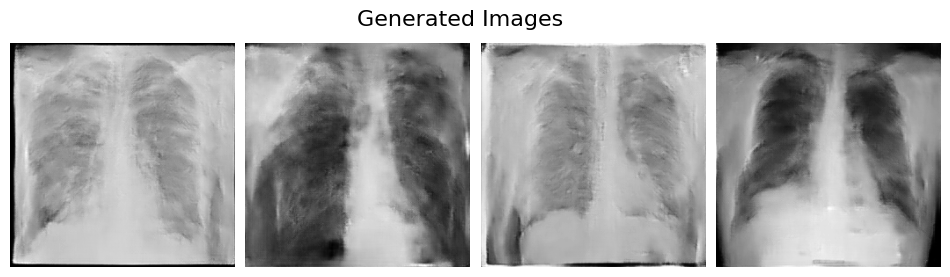

Epoch: 3000 [Discriminator loss: 0.348109] [Generator loss: 2.112473]
Time taken to train the model:  74.31847122907638  minutes


In [ ]:
# Try to load the saved losses from a file
try:
    with open('/content/drive/MyDrive/Models/Weight/losses.pkl', 'rb') as f:
        losses = pickle.load(f)
        disc_losses_saved, gen_losses_saved = losses
except FileNotFoundError:
    # If the file is not found, initialize empty lists for losses
    disc_losses_saved, gen_losses_saved = [], []

# Assign the saved losses to new variables
disc_losses = disc_losses_saved
gen_losses = gen_losses_saved

# Start the timer to calculate training time
st = time.time()

# Loop through the epochs
for epoch in range(start_epoch,end_epoch):
    # Loop through the batches
    for batch in range(steps_per_epoch):
        # Generate input noise for the generator
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))

        # Generate fake data using the generator
        fake_data = generator.predict(input_gen)
        
        # Randomly select real data samples
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, width, height, channel))
        
        # Concatenate real and fake data as input for the discriminator
        input_disc = np.concatenate((real_data, fake_data))

        # Create labels for the discriminator
        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9       # For flexibility used 0.9 instead of 1
        label_disc[batch_size:] = 0.1       # For flexibility used 0.1 instead of 0

         # Train the discriminator on the batch and get the loss
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

         # Create labels for the generator
        label_gen = np.ones(batch_size)

        # Train the GAN on the batch and get the loss
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    # Append the losses to the respective lists
    disc_losses.append(loss_disc)
    gen_losses.append(loss_gen)
    
    # Display generated images every 10 epochs
    if epoch % 10 == 0:
        clear_output(wait=True)
        show_generated_images("Generated Images", epoch)

    # Print the epoch number and the current loss values
    print("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (epoch, loss_disc, loss_gen))

    # Save the losses to a file using pickle so losses over all sessions can be visualized
    losses = (disc_losses, gen_losses)
    with open('/content/drive/MyDrive/Models/Weight/losses.pkl', 'wb') as f:
        pickle.dump(losses, f)

# Stop the timer and print the time taken for training
ft = time.time()
print("Time taken to train the model: ", (ft-st)/60, " minutes")

In [ ]:
# Save the weights of the GAN model to a file
gan.save_weights('/content/drive/MyDrive/Models/Weight/3000_gan_weights.hdf5')

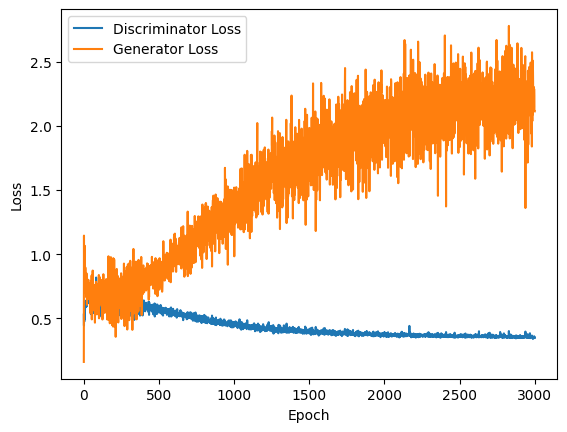

In [ ]:
# Clip the generator and discriminator losses to a maximum value of 5(for better visualization)
capped_gen_losses = np.clip(gen_losses, None, 5)
capped_disc_losses = np.clip(disc_losses, None, 5)

# Plot the discriminator and generator losses over the epochs
plt.plot(range(end_epoch), capped_disc_losses, label='Discriminator Loss')
plt.plot(range(end_epoch), capped_gen_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the loss graph as an image file
plt.savefig("/content/drive/MyDrive/Models/Weight/loss_graph.png", transparent=True)

# Display the loss graph
plt.show()

In [ ]:
# Load the saved losses from the file
with open('/content/drive/MyDrive/Models/Weight/losses.pkl', 'rb') as f:
    losses = pickle.load(f)

# Unpack the loaded losses into separate variables
disc_losses_loaded, gen_losses_loaded = losses

# Print the sizes of the loaded discriminator and generator losses(should match total number of epochs + 1)
print("Discriminator losses size:", len(disc_losses_loaded))
print("Generator losses size:", len(gen_losses_loaded))

Discriminator losses size: 3001
Generator losses size: 3001


In [13]:
# Define the path to the image folder
image_folder = '/content/drive/MyDrive/Dataset/Test/'

# Get a list of image files in the folder (excluding hidden files)
files = [f for f in os.listdir(image_folder) if not f.startswith('.') and not f.startswith('__')]

# Sort the files based on the numerical part of the file name
files.sort(key=lambda x: int(x.split('.')[0]))

# Create a list of image paths
images = [os.path.join(image_folder, file) for file in files]

# Set the duration for each frame in the GIF
frame_duration = 0.2

# Create a GIF writer with the specified file name, mode, and frame duration
with imageio.get_writer('Conv_gif_3000.gif', mode='I', duration=frame_duration) as writer:
    # Iterate over each image path and add it to the GIF writer
    for image in images:
        img = imageio.imread(image)
        writer.append_data(img)

<ipython-input-13-081196b181e8>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image)


In [ ]:
# Save the generator model to the specified path
generator.save('/content/drive/MyDrive/Models/Weight/gen3000.h5')

# Save the discriminator model to the specified path
discriminator.save('/content/drive/MyDrive/Models/Weight/dis3000.h5')

**4. Generate images and calculate SSIM and PSNR**

1/1 [==============================] - 1s 568ms/step


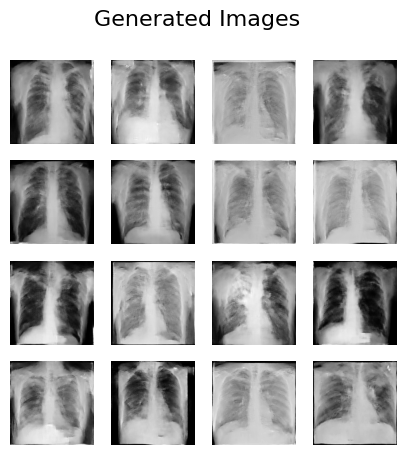

In [18]:
# Load the generator model from the specified path
gen3000 = load_model('/content/drive/MyDrive/Models/Weight/gen3000.h5')

# Generate random noise for input to the generator
noise = np.random.normal(0, 1, size=(16, noise_dim))

# Generate images using the loaded generator
imgs = gen3000.predict(noise)

# Rescale the generated images from [-1,1] to [0,1]
imgs = 0.5 * imgs + 0.5

# Display the generated images in a grid
plt.figure(figsize=(5,5)) 
i = 1
for img in imgs:
    plt.subplot(4, 4, i)
    plt.imshow(img.reshape((height,width,channel)), cmap='gray')
    plt.axis('off')
    i+=1

# Set the title of the plot
plt.suptitle("Generated Images", fontsize = 16)

# Save the plot as an image
plt.savefig("/content/drive/MyDrive/Models/Weight/group_gen_img.png", transparent=True)

# Show the plot
plt.show()

In [21]:
# Load the trained generator model from the specified model path
model_path = '/content/drive/MyDrive/Models/Weight/gen3000.h5'
generator_model = load_model(model_path)

# Specify the number of images to generate, noise dimension, and generate random noise vectors
num_images = 4
noise_dim = 128
noise = np.random.normal(0, 1, size=(num_images, noise_dim))

# Generate images using the generator model
generated_images = generator_model.predict(noise)

# Print the shape of the generated images array
print(generated_images.shape)

# Specify the directory to save the generated images
save_dir = '/content/drive/MyDrive/Dataset/my_generated_images/'

# Iterate through each generated image and save them as grayscale PNG files
for i, img in enumerate(generated_images):
    # Transform pixel values to the range of 0 to 1
    img = 0.5 * img + 0.5

    # Create a figure for the grayscale image
    plt.figure(figsize=(5, 5))

    # Display the grayscale image without axis
    plt.imshow(img.reshape((height,width,channel)), cmap='gray')
    plt.axis('off')

    # Save the grayscale image as a PNG file with a unique name
    plt.savefig(save_dir + f'gen_img_{i}.png', bbox_inches='tight', pad_inches=0)

    # Close the plot
    plt.close()

1/1 [==============================] - 0s 147ms/step
(4, 256, 256, 1)


In [14]:
# Calculation functions
def calculate_ssim(image1, image2):
    return ssim(image1, image2, multichannel=True)

def calculate_psnr(image1, image2):
    return psnr(image1, image2, data_range=image2.max())

# Load images from drive
image1_path = '/content/drive/MyDrive/Dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-80.png'
image2_path = '/content/drive/MyDrive/Dataset/SyntheticData/gen1_img_18.png'
image3_path = '/content/drive/MyDrive/Dataset/SyntheticData/gen1_img_1173.png'
image4_path = '/content/drive/MyDrive/Dataset/SyntheticData/gen1_img_1325.png'

# Read and preprocess image1 (Real Image)
image1 = cv2.imread(image1_path)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image1 = cv2.resize(image1, (256, 256))
image1 = np.expand_dims(image1, axis=-1)

# Read and preprocess image2 (Generated Image)
image2 = cv2.imread(image2_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
image2 = cv2.resize(image2, (256, 256))
image2 = np.expand_dims(image2, axis=-1)

# Read and preprocess image3 (Generated Image)
image3 = cv2.imread(image3_path)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
image3 = cv2.resize(image3, (256, 256))
image3 = np.expand_dims(image3, axis=-1)

# Read and preprocess image4 (Generated Image)
image4 = cv2.imread(image4_path)
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)
image4 = cv2.resize(image4, (256, 256))
image4 = np.expand_dims(image4, axis=-1)

In [15]:
# Calculate SSIM and PSNR values between image1 and image2
ssim_value = calculate_ssim(image1, image2)
psnr_value = calculate_psnr(image1, image2)

# Calculate SSIM and PSNR values between image1 and image3, and accumulate the results
ssim_value += calculate_ssim(image1, image3)
psnr_value += calculate_psnr(image1, image3)

# Calculate SSIM and PSNR values between image1 and image4, and accumulate the results
ssim_value += calculate_ssim(image1, image4)
psnr_value += calculate_psnr(image1, image4)

# Calculate and print the average SSIM and PSNR values
print("SSIM:", ssim_value/3)
print("PSNR:", psnr_value/3)

SSIM: 0.45267597050318775
PSNR: 12.816144679811222


<ipython-input-14-5347c4272bcd>:3: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image1, image2, multichannel=True)
